📌 Project Introduction

In this project, we use three different models to classify images of five different venues: decision tree supervised, decision tree semi-supervised and CNN supervised.
This notebook adress only the second model.

📌 Semi-Supervised Learning uses both labeled and unlabeled data to improve accuracy. By leveraging the structure of decision trees, this approach enhances predictions by utilizing all available data

📌 In this Project, we will:

    Analyze customer data provided in data set (EDA= exploratory data analysis) 
    Build two models that can classify images

📌 Install  and importing Libraries

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask.diagnostics import ProgressBar
from PIL import Image
import dask.bag as db

In [6]:
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
import platform
from sklearn.semi_supervised import LabelPropagation
from sklearn.tree import DecisionTreeClassifier

## Decision trees for SemiSupervised learning


#### Code for use gpu in Mac

In [4]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
print(f"Python Platform: {platform.platform()}")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-10.16-x86_64-i386-64bit
MPS (Apple Metal) is AVAILABLE
Target device is mps


📌 Load images

In [1]:
img_path = 'final_dataset'
images = []
labels = []

label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}

In [7]:
device = torch.device('cpu')

In [8]:
transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
for name, num in label_map.items():
    for img_name in os.listdir(os.path.join(img_path, name)):
        img_file = Image.open(os.path.join(img_path, name, img_name)).convert('RGB')
        img = transforms(img_file).to(device)
        images.append(img.cpu().numpy())
        labels.append(num)
    print(f"finish to read all {name} images")


X = np.array(images)
Y = np.array(labels)



X = X / 255.0

# Reshape
X_reshape = X.reshape(X.shape[0], -1)


finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images


📌 Train and Test data split

In [10]:
num_cluster = 5
X_train, X_test, Y_train, Y_test = train_test_split(X_reshape,Y, test_size=0.2, random_state=42)

📌 Labeled and unlabeled data split

In [11]:
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train, test_size=0.8, random_state=42)
Y_train_unlabeled = np.full(Y_unlabeled.shape, -1)

In [ ]:
X_labeled_train = X_labeled
X_unlabeled_train = X_unlabeled
Y_unlabeled_train = Y_train_unlabeled
Y_labeled_train = Y_labeled

decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=20, min_samples_split=20, min_samples_leaf=8)


for i in range(0,15):
    lprediction = decision_tree.fit(X_labeled_train, Y_labeled_train)
    
    Y_unlabeled_pred_proba = lprediction.predict_proba(X_unlabeled_train)
    Y_unlabeled_pred = lprediction.predict(X_unlabeled_train)

    
    confidence_scores = np.max(Y_unlabeled_pred_proba, axis=1)
    num_high_confidence = int(0.10 * len(Y_unlabeled_pred))
    top_indices = np.argsort(confidence_scores)[-num_high_confidence:]

    X_high_confidence = X_unlabeled_train[top_indices]
    Y_high_confidence = Y_unlabeled_pred[top_indices]

    
    mask = np.ones(len(X_unlabeled_train), dtype=bool)
    mask[top_indices] = False
    X_unlabeled_train = X_unlabeled_train[mask]
    Y_unlabeled_train = Y_unlabeled_train[mask]

    X_labeled_train = np.concatenate((X_labeled_train, X_high_confidence))
    Y_labeled_train = np.concatenate((Y_labeled_train, Y_high_confidence))

Accuracy: 0.42567567567567566; Precision: 0.40310472624728433; Recall: 0.42313104260451684; F1: 0.40827994666826994


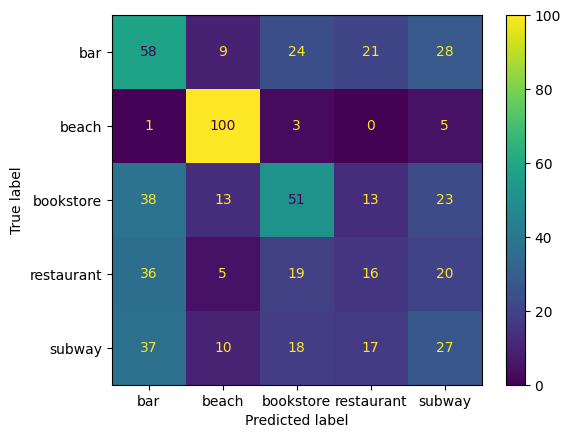

In [13]:
# Evaluation
Y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
f1 = f1_score(Y_test, Y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, Y_pred)
print(f"Accuracy: {accuracy}; Precision: {precision}; Recall: {recall}; F1: {f1}")
confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
confusion_matrix_display.plot()
plt.show()